In [1]:
import sys

sys.path.append("..")

In [2]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from model.holo import HoloConfig, HoloForCausalLM
from model.long import LongConfig, LongForCausalLM
# from model.long_new import LongConfig, LongHFModel
from transformers import MambaConfig, MambaForCausalLM
from transformers import GPT2Config, GPT2LMHeadModel
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm 
import numpy as np
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
import gc
import math

In [3]:
class NeedleHaystackDataset(Dataset):
    def __init__(self, size=2000, min_len=32, max_len=64, vocab_size=128, depth=None):
        """
        depth: Float between 0.0 and 1.0. 
               If None, depth is randomized for every sample (0% to 100%).
               If set (e.g., 0.5), the needle is always placed at 50% context.
        """
        self.size = size
        self.min_len = min_len
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.depth = depth
        
        # We reserve the last token as the specific "Prompt" trigger
        self.prompt_token = torch.tensor([vocab_size - 1]) 
        
    def __len__(self): 
        return self.size

    def __getitem__(self, idx):
        # 1. Determine total length of the sequence
        curr_len = np.random.randint(self.min_len, self.max_len + 1)
        
        # 2. Generate the Key (Needle)
        # Range: [1, vocab-2] to avoid padding (0) and prompt token (vocab-1)
        key = torch.randint(1, self.vocab_size - 1, (1,))
        
        # 3. Generate Noise (Haystack)
        # We need space for 2 prompt tokens and 2 key tokens (4 tokens total overhead)
        noise_len = max(0, curr_len - 4)
        noise = torch.randint(1, self.vocab_size - 1, (noise_len,))
        
        # 4. Determine Insertion Point (Depth)
        if self.depth is not None:
            # Fixed depth (e.g., 0.9 for 90% deep)
            insert_idx = int(noise_len * self.depth)
        else:
            # Fully Random depth (0% to 100%)
            # FIX: Previously this was noise_len // 2 (biased to start)
            insert_idx = torch.randint(0, noise_len + 1, (1,)).item()
        
        # 5. Construct Sequence
        # [Noise Part A] -> [Prompt] -> [Key] -> [Noise Part B] -> [Prompt] -> [Key (Target)]
        input_ids = torch.cat([
            noise[:insert_idx], 
            self.prompt_token, key,      
            noise[insert_idx:], 
            self.prompt_token, key       
        ])
        
        # 6. Create Labels (Mask everything except the final Key)
        labels = input_ids.clone()
        # Mask everything up to the final token
        labels[:-1] = -100 
        
        return {"input_ids": input_ids, "labels": labels}

In [4]:
class MultiScaleLongAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.h = heads
        self.d = dim // heads
        
        self.q_proj = nn.Linear(dim, dim, bias=False)
        self.k_proj = nn.Linear(dim, dim, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)
        self.o = nn.Linear(dim, dim, bias=False)
        
        # Local Conv for "Trigger Detection"
        self.conv = nn.Conv1d(dim, dim, kernel_size=4, groups=dim, padding=3)
        self.input_gate = nn.Linear(dim, dim, bias=True)
        
        # Spectral Gammas: [0.9 ... 1.0]
        decays = torch.linspace(0.9, 1.0, heads)
        decays[-1] = 1.0 # Ensure absolute stability
        self.gamma = nn.Parameter(decays.view(1, 1, heads, 1), requires_grad=False)
        
        self.ln = nn.LayerNorm(dim)
        nn.init.constant_(self.input_gate.bias, 1.0) # Start Open

    def forward(self, x):
        B, T, C = x.shape
        
        # Short Convolution (Locality)
        x_c = self.conv(x.transpose(1, 2))[:, :, :T].transpose(1, 2)
        x_c = F.silu(x_c)
        
        q = self.q_proj(x).view(B, T, self.h, self.d)
        k = self.k_proj(x).view(B, T, self.h, self.d)
        v = self.v_proj(x).view(B, T, self.h, self.d)
        
        # Input Gate
        i_gate = F.relu(self.input_gate(x_c)).view(B, T, self.h, self.d)
        
        k = F.normalize(k, p=2, dim=-1)
        q = F.normalize(q, p=2, dim=-1)
        
        kv = (k * v) * i_gate 
        
        # DUAL MODE SWITCHING
        if T > 1024: 
            # RNN MODE (Inference - O(1) Memory)
            out_list = []
            state = torch.zeros(B, self.h, self.d, device=x.device)
            gamma_sq = self.gamma.view(1, self.h, 1)
            
            for t in range(T):
                kv_t = kv[:, t]
                q_t = q[:, t]
                state = state * gamma_sq + kv_t
                out_t = (state * q_t).reshape(B, -1)
                out_list.append(out_t)
            out = torch.stack(out_list, dim=1)
        else:
            # PARALLEL MODE (Training - O(log N) Parallelism)
            # This is the "Cumsum" trick that makes training stable
            t_steps = torch.arange(T, device=x.device).view(1, T, 1, 1).float()
            decay = torch.pow(self.gamma, t_steps)
            D_inv = 1.0 / (decay + 1e-9)
            
            mem_unscaled = torch.cumsum(kv * D_inv, dim=1)
            mem = mem_unscaled * decay
            
            mem_flat = mem.reshape(B, T, C)
            out = (mem_flat * q.reshape(B, T, C))

        return self.ln(self.o(out))

class LongNet(nn.Module):
    def __init__(self, vocab_size, dim, layers, heads):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, dim)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(dim), MultiScaleLongAttention(dim, heads), nn.LayerNorm(dim),
                nn.Sequential(nn.Linear(dim, 4*dim), nn.GELU(), nn.Linear(4*dim, dim))
            ) for _ in range(layers)])
        self.head = nn.Linear(dim, vocab_size, bias=False)
    def forward(self, idx):
        x = self.wte(idx)
        for block in self.blocks: 
            x = block[1](block[0](x)) + x
            x = block[3](block[2](x)) + x
        return self.head(x)


In [5]:
def pad_collate_fn(batch):
    inputs = rnn_utils.pad_sequence([x['input_ids'] for x in batch], batch_first=True, padding_value=0)
    labels = rnn_utils.pad_sequence([x['labels'] for x in batch], batch_first=True, padding_value=-100)
    return {"input_ids": inputs, "labels": labels}


In [6]:
VOCAB_SIZE = 128
DIM = 64
LAYERS = 2
HEADS = 4
EPOCHS = 10
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


config_kwargs = {
     "vocab_size": VOCAB_SIZE, 
     "ssm_cfg": {"dropout": 0.0 }
}
mamba_config = MambaConfig(
    hidden_size = DIM,
    num_hidden_layers = LAYERS, 
    **config_kwargs
)
mamba_model = MambaForCausalLM(mamba_config).to(DEVICE)

gpt2_config = GPT2Config(
    vocab_size=VOCAB_SIZE,
    # 1. Context Window
    # GPT-2 has a HARD limit. You must set this >= your max haystack length.
    n_positions=8192, 
    
    # 2. Dimensions (Matching your request)
    n_embd=128,       # This is "hidden_size"
    n_layer=2,        # This is "num_hidden_layers"
    
    # 3. Heads
    # n_embd (128) must be divisible by n_head. 
    # 4 heads gives 32 dimension per head (standard).
    n_head=4, 
    
    # 4. Cleanup
    bos_token_id=0,
    eos_token_id=0,
    
    # Optional: Disable dropout for pure algorithmic testing (like your Mamba config)
    resid_pdrop=0.0,
    embd_pdrop=0.0,
    attn_pdrop=0.0,
    use_cache=False # False for training with Gradient Checkpointing, True for generation
)

model_gpt2 = GPT2LMHeadModel(gpt2_config).to(DEVICE)

In [7]:
class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.d_model = d_model
        self.d_inner = int(expand * d_model)
        self.dt_rank = math.ceil(d_model / 16)
        self.d_state = d_state
        self.in_proj = nn.Linear(d_model, self.d_inner * 2, bias=False)
        self.conv1d = nn.Conv1d(self.d_inner, self.d_inner, d_conv, groups=self.d_inner, padding=d_conv - 1)
        self.x_proj = nn.Linear(self.d_inner, self.dt_rank + self.d_state * 2, bias=False)
        self.dt_proj = nn.Linear(self.dt_rank, self.d_inner, bias=True)
        
        A = torch.arange(1, self.d_state + 1, dtype=torch.float32).repeat(self.d_inner, 1)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(self.d_inner))
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False)
        nn.init.constant_(self.dt_proj.bias, -2.0)

    def forward(self, x):
        batch, seqlen, dim = x.shape
        x_and_z = self.in_proj(x)
        x_src, z = x_and_z.chunk(2, dim=-1)
        x_conv = self.conv1d(x_src.transpose(1, 2))[:, :, :seqlen]
        x_conv = F.silu(x_conv)
        x_dbl = self.x_proj(x_conv.transpose(1, 2))
        dt, B, C = torch.split(x_dbl, [self.dt_rank, self.d_state, self.d_state], dim=-1)
        dt = F.softplus(self.dt_proj(dt)).transpose(1, 2)
        B = B.transpose(1, 2)
        C = C.transpose(1, 2)
        A = -torch.exp(self.A_log.float())
        y = []
        state = torch.zeros(batch, self.d_inner, self.d_state, device=x.device)
        for t in range(seqlen):
            dt_t = dt[:, :, t]
            state = state * torch.exp(torch.einsum('bd, dn -> bdn', dt_t, A)) + \
                    torch.einsum('bd, bn -> bdn', dt_t, B[:,:,t]) * x_conv[:,:,t].unsqueeze(-1)
            y.append(torch.einsum('bdn, bn -> bd', state, C[:,:,t]))
        y = torch.stack(y, dim=1)
        y = y + x_conv.transpose(1, 2) * self.D
        return self.out_proj(y * F.silu(z))

class MambaModel(nn.Module):
    def __init__(self, vocab_size, dim, layers):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, dim)
        self.blocks = nn.ModuleList([nn.Sequential(MambaBlock(dim), nn.LayerNorm(dim)) for _ in range(layers)])
        self.head = nn.Linear(dim, vocab_size, bias=False)
    def forward(self, idx):
        x = self.wte(idx)
        for block in self.blocks: x = block(x) + x
        return self.head(x)


In [8]:
long_config = LongConfig(
    vocab_size = VOCAB_SIZE, 
    hidden_size = 64, 
    num_hidden_layers = 2, 
    num_heads = 4,
    hybrid_ratio = 2
)
long_llm = LongForCausalLM(long_config).to(DEVICE)

print(long_llm)

LongForCausalLM(
  (long_model): LongModel(
    (wte): Embedding(128, 64)
    (layers): ModuleList(
      (0): LongBlock(
        (attn): LongAttention(
          (q_proj): Linear(in_features=64, out_features=64, bias=False)
          (k_proj): Linear(in_features=64, out_features=64, bias=False)
          (v_proj): Linear(in_features=64, out_features=64, bias=False)
          (conv): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
          (input_gate_proj): Linear(in_features=64, out_features=64, bias=True)
          (output_gate_proj): Linear(in_features=64, out_features=64, bias=True)
          (gamma_proj): Linear(in_features=64, out_features=4, bias=True)
          (o_proj): Linear(in_features=64, out_features=64, bias=False)
          (grp_norm): GroupNorm(4, 64, eps=1e-05, affine=True)
          (mem_norm): GroupNorm(4, 64, eps=1e-05, affine=True)
        )
        (mlp): LongMLP(
          (fc1): Linear(in_features=64, out_features=256, bias=False)
     

In [9]:
long_llm = LongNet(VOCAB_SIZE, DIM, LAYERS, HEADS).to(DEVICE)
print(long_llm)

LongNet(
  (wte): Embedding(128, 64)
  (blocks): ModuleList(
    (0-1): 2 x Sequential(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (1): MultiScaleLongAttention(
        (q_proj): Linear(in_features=64, out_features=64, bias=False)
        (k_proj): Linear(in_features=64, out_features=64, bias=False)
        (v_proj): Linear(in_features=64, out_features=64, bias=False)
        (o): Linear(in_features=64, out_features=64, bias=False)
        (conv): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
        (input_gate): Linear(in_features=64, out_features=64, bias=True)
        (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (3): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
      )
    )
  )
  (head): Linear(in_features=


🚀 Training Long-LLM (HF)...
   Ep 5: Loss 7.0718
   Ep 10: Loss 0.0164
   🧪 Benchmarking Long-LLM (HF)...
      Len 64: 99.5%
      Len 128: 99.0%
      Len 256: 99.5%
      Len 512: 99.5%
      Len 1024: 99.0%
      Len 2048: 100.0%
      Len 4096: 99.0%
      Len 8192: 97.5%
      Len 16384: 96.5%
      Len 32768: 95.5%

🚀 Training Mamba (HF)...
   Ep 5: Loss 0.4171
   Ep 10: Loss 0.0181
   🧪 Benchmarking Mamba (HF)...
      Len 64: 100.0%
      Len 128: 100.0%
      Len 256: 100.0%
      Len 512: 100.0%
      Len 1024: 100.0%
      Len 2048: 100.0%
      Len 4096: 89.5%
      Len 8192: 41.5%
      Len 16384: 8.0%


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


      Len 32768: 3.5%

🚀 Training GPT-2...
   Ep 5: Loss 6.9110
   Ep 10: Loss 6.9048
   🧪 Benchmarking GPT-2...
      Len 64: 0.0%
      Len 128: 0.0%
      Len 256: 0.5%
      Len 512: 0.0%
      Len 1024: 0.0%
      Len 2048: 0.0%
      Len 4096: 0.0%
      Len 8192: 0.0%
      Len 16384: 0.0%
      Len 32768: 0.0%

📊 Generating Figure...


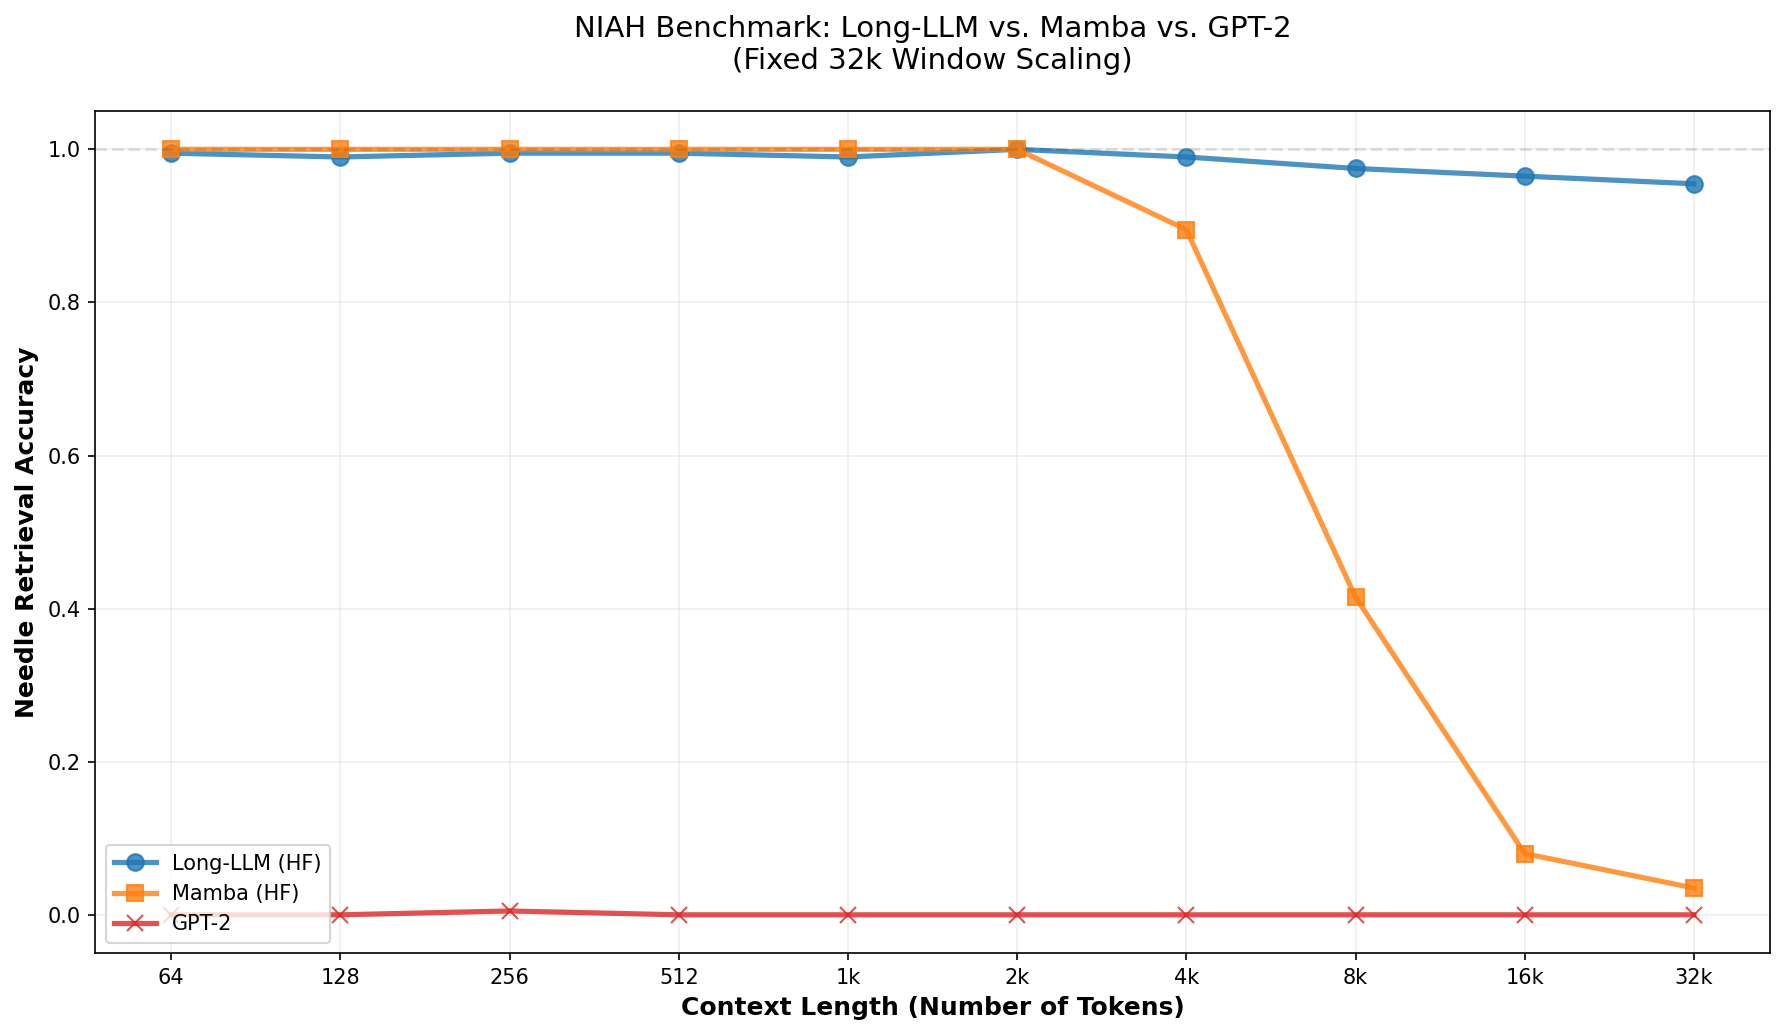

✅ Visualization saved as 'benchmark_results.png'.


In [10]:
def run_benchmark():
    VOCAB_SIZE = 1000
    DIM = 64
    LAYERS = 2
    HEADS = 4
    EPOCHS = 10
    BATCH_SIZE = 64
    
    # --- 1. Model Setup (Hugging Face Style) ---
    
    # Setup Long-LLM Config
    # Assuming LongConfig is your custom config class
    long_config = LongConfig(
        vocab_size = VOCAB_SIZE, 
        hidden_size = 64, 
        num_hidden_layers = 2, 
        num_heads = 4,
        hybrid_ratio = 2,
        gate_init_bias = 0.0,
    )
    long_llm = LongForCausalLM(long_config).to(DEVICE)

    # long_llm = LongNet(VOCAB_SIZE, DIM, LAYERS, HEADS).to(DEVICE)

    # Setup Mamba HF
    mamba_config = MambaConfig(
        vocab_size=VOCAB_SIZE,
        hidden_size=DIM,
        num_hidden_layers=LAYERS,
        ssm_cfg={"dropout": 0.0}
    )
    mamba_hf = MambaForCausalLM(mamba_config).to(DEVICE)

    # Setup GPT-2 HF
    gpt2_config = GPT2Config(
        vocab_size=VOCAB_SIZE, n_positions=32768, n_embd=DIM, n_layer=LAYERS, n_head=HEADS,
        resid_pdrop=0.0, embd_pdrop=0.0, attn_pdrop=0.0, use_cache=False
    )
    gpt2_model = GPT2LMHeadModel(gpt2_config).to(DEVICE)

    models = {
        "Long-LLM (HF)": long_llm,
        # "Long-LLM (NET)": long_llm,
        "Mamba (HF)": mamba_hf,
        "GPT-2": gpt2_model
    }
    
    test_lengths = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
    results = {name: [] for name in models}
    
    for name, model in models.items():
        print(f"\n🚀 Training {name}...")
        
        opt = optim.AdamW(model.parameters(), lr=0.001)
        train_ds = NeedleHaystackDataset(size=10000, min_len=32, max_len=128, vocab_size=VOCAB_SIZE)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=pad_collate_fn, shuffle=True)
        
        model.train()
        for ep in range(EPOCHS):
            loss_list = []
            for batch in train_loader:
                x, y = batch['input_ids'].to(DEVICE), batch['labels'].to(DEVICE)
                
                # --- HF-STYLE FORWARD ---
                # HF models can calculate loss internally if labels are passed
                outputs = model(input_ids=x, labels=y)
                
                if hasattr(outputs, 'loss') and outputs.loss is not None:
                    loss = outputs.loss
                else:
                    # Fallback for models that don't compute loss internally
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    shift_logits = logits[:, :-1, :].contiguous()
                    shift_labels = y[:, 1:].contiguous()
                    loss = F.cross_entropy(shift_logits.view(-1, VOCAB_SIZE), shift_labels.view(-1))
                
                opt.zero_grad()
                loss.backward()
                opt.step()
                loss_list.append(loss.item())
                
            if (ep+1) % 5 == 0:
                print(f"   Ep {ep+1}: Loss {np.mean(loss_list):.4f}")

        # --- 2. Benchmark Evaluation ---
        print(f"   🧪 Benchmarking {name}...")
        model.eval()
        for L in test_lengths:
            gc.collect(); torch.cuda.empty_cache()
            eval_batch = 64 if L <= 1024 else (8 if L <= 8192 else 1)
            
            test_ds = NeedleHaystackDataset(size=200, min_len=L, max_len=L, vocab_size=VOCAB_SIZE, depth=0.5)
            test_loader = DataLoader(test_ds, batch_size=eval_batch, collate_fn=pad_collate_fn)
            
            hits, total = 0, 0
            try:
                with torch.no_grad():
                    for batch in test_loader:
                        x, y = batch['input_ids'].to(DEVICE), batch['labels'].to(DEVICE)
                        outputs = model(x)
                        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                        
                        for i in range(x.size(0)):
                            valid = (y[i] != -100).nonzero(as_tuple=True)[0]
                            if len(valid) == 0: continue
                            
                            target_pos = valid[-1].item()
                            pred = logits[i, target_pos-1].argmax().item()
                            if pred == y[i, target_pos].item(): hits += 1
                            total += 1
                            
                acc = hits / total if total > 0 else 0
                results[name].append(acc)
                print(f"      Len {L}: {acc:.1%}")
            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    print(f"      Len {L}: FAILED (OOM)")
                else:
                    print(f"      Len {L}: FAILED ({e})")
                results[name].append(0.0)

    # --- 3. Visualization ---
    # (Same as your provided code, just use results dictionary)
    # ...
    print("\n📊 Generating Figure...")
    plt.figure(figsize=(12, 7), dpi=150)
    
    # Custom styling for professional look
    markers = {
        "Long-LLM (HF)": "o",  # Circle
        "Mamba (HF)": "s",     # Square
        "GPT-2": "x"           # Cross
    }
    colors = {
        "Long-LLM (HF)": "#1f77b4", # Deep Blue
        "Mamba (HF)": "#ff7f0e",    # Bright Orange
        "GPT-2": "#d62728"          # Crimson Red
    }

    for name, accs in results.items():
        # Plotting results
        plt.plot(
            test_lengths, 
            accs, 
            marker=markers.get(name, "d"), 
            color=colors.get(name, "#7f7f7f"), 
            linewidth=2.5, 
            markersize=8,
            label=name,
            alpha=0.8
        )
        
    # Formatting the X-axis for context lengths
    plt.xscale('log', base=2)
    x_labels = [str(l) if l < 1024 else f"{l//1024}k" for l in test_lengths]
    plt.xticks(test_lengths, x_labels)
    
    # Labels and Legend
    plt.xlabel("Context Length (Number of Tokens)", fontsize=12, fontweight='bold')
    plt.ylabel("Needle Retrieval Accuracy", fontsize=12, fontweight='bold')
    plt.title("NIAH Benchmark: Long-LLM vs. Mamba vs. GPT-2\n(Fixed 32k Window Scaling)", fontsize=14, pad=20)
    
    plt.ylim(-0.05, 1.05)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(frameon=True, loc='lower left', fontsize=10)
    
    # Adding a target line for 100% accuracy
    plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.1)

    plt.tight_layout()
    plt.savefig("benchmark_results.png")
    plt.show()
    print("✅ Visualization saved as 'benchmark_results.png'.")

run_benchmark()